## Install library

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
'''
!pip install contractions
!pip install bs4
!pip install nltk
!pip install tensorflow
!pip install keras-tuner
!pip install pydot
!pip install xgboost
import nltk
nltk.download('punkt_tab')
'''


"\n!pip install contractions\n!pip install bs4\n!pip install nltk\n!pip install tensorflow\n!pip install keras-tuner\n!pip install pydot\n!pip install xgboost\nimport nltk\nnltk.download('punkt_tab')\n"

In [7]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mimuw2022/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Load data

In [8]:
import pandas as pd

df = pd.read_csv('all-data.csv', delimiter=',', encoding='latin-1', header=None)
df = df.rename(columns=lambda x: ['Sentiment', 'Sentence'][x])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [9]:
df = df[['Sentence', 'Sentiment']]
df.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


## A (very) short Exploratory data analysis

In [10]:
df = df[df.Sentiment != "neutral"]
df.head()

,Sentence,Sentiment
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
6,"For the last quarter of 2010 , Componenta 's n...",positive


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1967 entries, 2 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   1967 non-null   object
 1   Sentiment  1967 non-null   object
dtypes: object(2)
memory usage: 46.1+ KB


### Sentiment distribution

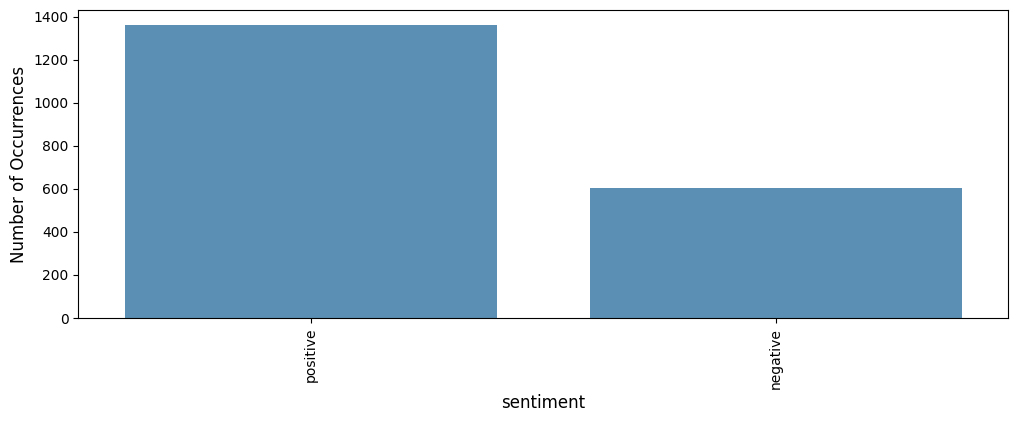

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## Data preparation

### Data cleaning

In [13]:
from bs4 import BeautifulSoup

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [14]:
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)
  
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [15]:
%%time
df.Sentence = pre_process_corpus(df.Sentence)

  0%|          | 0/1967 [00:00<?, ?it/s]


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/mimuw2022/nltk_data'
    - '/Users/mimuw2022/my_new_env/nltk_data'
    - '/Users/mimuw2022/my_new_env/share/nltk_data'
    - '/Users/mimuw2022/my_new_env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [16]:
df.head()

,Sentence,Sentiment
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
6,"For the last quarter of 2010 , Componenta 's n...",positive


### Handling imbalance (oversampling)

In [17]:
from sklearn.utils import resample
# Separate majority and minority classes in training data for upsampling 
data_majority = df[df['Sentiment'] == "positive"]
data_minority = df[df['Sentiment'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0]    # to match majority class
                                 ) # reproducible results
 
# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",df_balance.Sentiment.value_counts(),sep = "")

majority class before upsample: (1363, 2)
minority class before upsample: (604, 2)
After upsampling
Sentiment
positive    1363
negative    1363
Name: count, dtype: int64


### Data splitting

In [18]:
from sklearn.model_selection import train_test_split
X = df.Sentence
y = df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(df.Sentence, df.Sentiment, test_size=0.1)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1770,), (197,), (1770,), (197,))

### Tokenizer

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(X_train)

In [20]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=5215
Number of Documents=1770


### Sequence

In [21]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

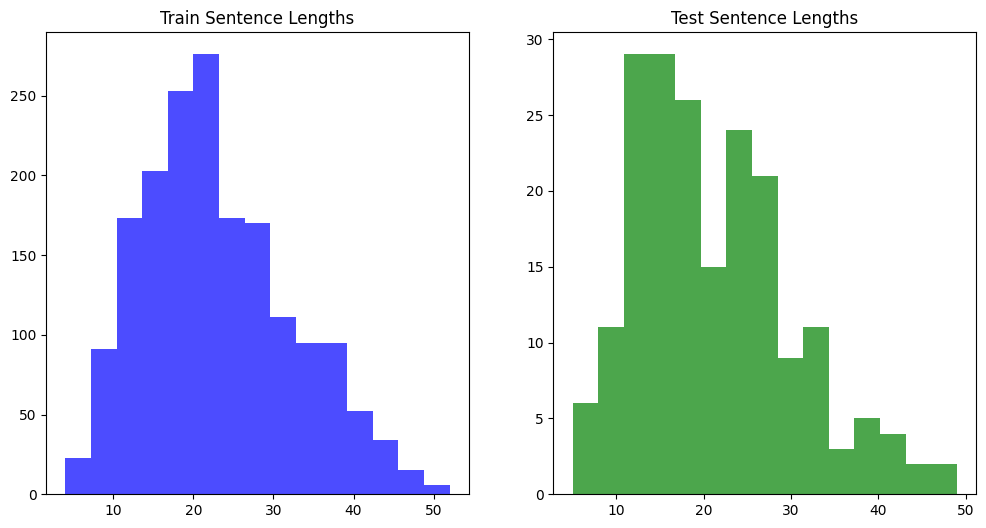

In [22]:
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]


# Plot histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(train_lens, bins=15, color='blue', alpha=0.7)
ax[0].set_title('Train Sentence Lengths')
ax[1].hist(test_lens, bins=15, color='green', alpha=0.7)
ax[1].set_title('Test Sentence Lengths')

plt.show()

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#padding
MAX_SEQUENCE_LENGTH = 30
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((1770, 30), (197, 30))

### Encoding Labels

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [25]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# CNN

### Build model

### Train model with hp tuning

In [27]:
import tensorflow as tf
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Assume that the following variables are defined appropriately:
#   vocab: Vocabulary size (e.g., 10000)
#   vec_size: Embedding dimension (fixed at 300)
#   MAX_SEQUENCE_LENGTH: Maximum length of input sequences

vec_size = 300  # Fixed embedding dimension

def build_model(hp):
    model = Sequential()
    
    # Embedding layer with fixed parameters
    model.add(Embedding(vocab, vec_size, input_length=MAX_SEQUENCE_LENGTH))
    
    # Convolution and pooling layers with fixed hyperparameters
    model.add(Conv1D(64, 8, activation="relu"))
    model.add(MaxPooling1D(2))
    
    # Dropout layer with a tunable dropout rate
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.05, max_value=0.25, step=0.05)))  # CHANGED
    
    model.add(Dense(8, activation="relu"))
    # Second dropout layer with the same tunable dropout rate
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.05, max_value=0.8, step=0.05)))  # CHANGED
    
    model.add(Dense(4, activation='relu'))
    # Third dropout layer with the same tunable dropout rate
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.05, max_value=0.8, step=0.05)))  # CHANGED
    
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
        metrics=['accuracy']
    )
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tune_dropout'  # a new project name to avoid conflicts with previous runs
)

# Early stopping callback (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Assume X_train, y_train, X_test, and y_test are your data splits.
tuner.search(X_train, y_train, epochs=20, validation_split=0.1, batch_size=32, callbacks=[early_stopping])

# Retrieve the best model and its hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.8757061958312988

Best val_accuracy So Far: 0.887005627155304
Total elapsed time: 00h 01m 02s
Best Hyperparameters:
{'dropout_rate': 0.2}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.4513  
Test Accuracy: 81.22%


## Evaluation

### Model Accuracy

In [28]:
from keras.models import load_model

#saved_model = load_model('./best_model/best_model_cnn1d.h5')
train_acc = best_model.evaluate(X_train, y_train, verbose=1)
test_acc = best_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.2900
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.4513 
Train: 95.82%, Test: 81.22%


### Identify Overfitting

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9459 - loss: 0.2321 - val_accuracy: 0.8870 - val_loss: 0.3413
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9615 - loss: 0.1722 - val_accuracy: 0.8757 - val_loss: 0.3063
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9669 - loss: 0.1194 - val_accuracy: 0.8757 - val_loss: 0.2900
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9752 - loss: 0.0885 - val_accuracy: 0.8644 - val_loss: 0.2917
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9858 - loss: 0.0651 - val_accuracy: 0.8644 - val_loss: 0.2882
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9845 - loss: 0.0637 - val_accuracy: 0.8644 - val_loss: 0.2935
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9934 - loss: 0.0389 - val_accuracy: 0.8701 - val_loss: 0.3006
Epoch 8/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9935 - loss: 0.0289 - val_accuracy: 0.

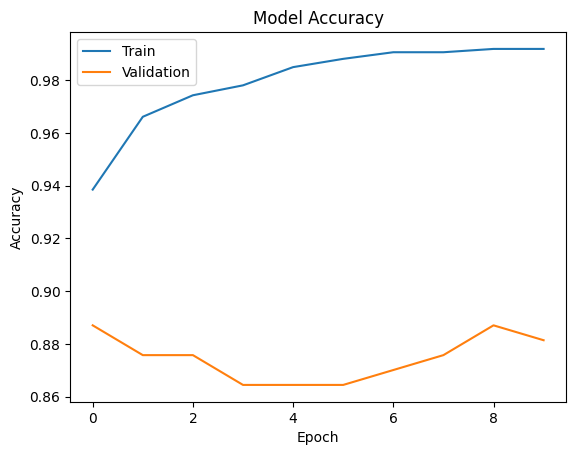

In [29]:
import matplotlib.pyplot as plt

# Train your model and obtain the history object
history = best_model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=4, callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


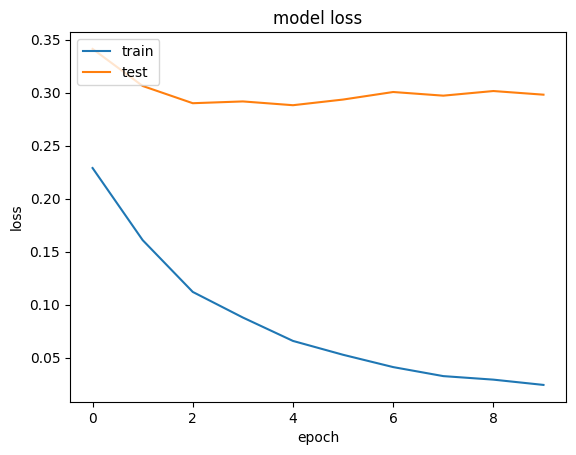

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
import tensorflow as tf
from keras.models import load_model
from keras.utils import plot_model  # For visualizing the model architecture


# ---------------------------------------------------
# Visualize the architecture of the model and save to a file.
# The diagram will include the shapes of the inputs and outputs of each layer.
# ---------------------------------------------------
plot_model(best_model, 
           to_file='model_architecture.png', 
           show_shapes=True,       # This will show output shape at each layer.
           show_layer_names=True)  # This will show each layer’s name.

print("Model architecture visual saved as 'model_architecture.png'.")



Model architecture visual saved as 'model_architecture.png'.


In [49]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ------------------------
# Assume best_model is already defined (via training/tuning) or loaded:
# best_model = load_model('./best_model/best_model_cnn1d.h5')
# ------------------------

# Evaluate on the training data and testing data.
train_results = best_model.evaluate(X_train, y_train, verbose=1)
test_results  = best_model.evaluate(X_test, y_test, verbose=1)

# Collect evaluation metrics into dictionaries for easy comparison.
train_metrics = {
    'loss': train_results[0],
    'accuracy': train_results[1]
}

test_metrics = {
    'loss': test_results[0],
    'accuracy': test_results[1]
}

# Make predictions on the training and testing datasets.
y_train_pred = (best_model.predict(X_train) > 0.5).astype(int)
y_test_pred = (best_model.predict(X_test) > 0.5).astype(int)

# ------------------------
# Additional Metrics Calculation
# ------------------------

# Training metrics
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, best_model.predict(X_train))

# Testing metrics
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, best_model.predict(X_test))

# ------------------------
# Print All Metrics
# ------------------------

# Training metrics
print(f"Train Loss: {train_metrics['loss']:.4f}, Train Accuracy: {train_metrics['accuracy']*100:.2f}%")
print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, Train AUC: {train_auc:.4f}")

# Testing metrics
print(f"Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}, Test AUC: {test_auc:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0252
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.4955 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Loss: 0.0479, Train Accuracy: 98.70%
Train Precision: 0.9871, Train Recall: 0.9943, Train F1 Score: 0.9907, Train AUC: 0.9985
Test Loss: 0.4333, Test Accuracy: 84.77%
Test Precision: 0.8333, Test Recall: 0.9615, Test F1 Score: 0.8929, Test AUC: 0.9210


### Confusion Matrix

In [32]:
def predictions(x):
    prediction_probs = best_model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

labels = ['positive', 'negative']
print("CNN 1D Accuracy: %.2f%%" % (accuracy_score(y_test, predictions(X_test))*100))
print("CNN 1D Precision: %.2f%%" % (precision_score(y_test, predictions(X_test), average="macro")*100))
print("CNN 1D Recall: %.2f%%" % (recall_score(y_test, predictions(X_test), average="macro")*100))
print("CNN 1D f1_score: %.2f%%" % (f1_score(y_test, predictions(X_test), average="macro")*100))
print('================================================\n') 
print(classification_report(y_test, predictions(X_test)))
pd.DataFrame(confusion_matrix(y_test, predictions(X_test)), index=labels, columns=labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
CNN 1D Accuracy: 84.77%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
CNN 1D Precision: 86.35%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN 1D Recall: 79.42%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN 1D f1_score: 81.48%

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.89      0.63      0.74        67
           1       0.83      0.96      0.89       130

    accuracy                           0.85       197
   macro avg       0.86      0.79      0.81       197
weighted avg       0.85      0.85      0.84       197

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,positive,negative
positive,42,25
negative,5,125


### ROC AUC

In [34]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
model AUC score: 79.42%


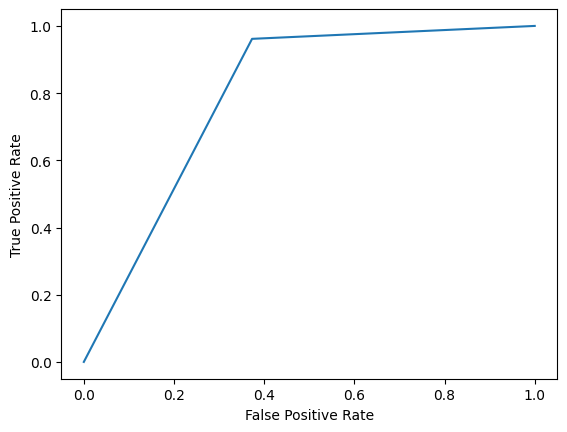

In [35]:
plot_roc_curve(y_test, predictions(X_test))
print("model AUC score: %.2f%%" % (roc_auc_score(y_test, predictions(X_test))*100))

# XGBoost

In [36]:
# For the pipeline and hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold





In [37]:

#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=50) #25 iterations

In [38]:
xgb_model  = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', rs)
])

In [39]:

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df.Sentence, df.Sentiment, test_size=0.1)


if isinstance(X_train_xgb, list):
    X_train_xgb = [" ".join(doc) if isinstance(doc, list) else str(doc) for doc in X_train_xgb]

# Ensure X_train is a flat list of strings
if isinstance(X_test_xgb, list):
    X_test_xgb = [" ".join(doc) if isinstance(doc, list) else str(doc) for doc in X_test_xgb]


# Convert string labels to numeric
label_encoder = LabelEncoder()
y_train_xgb = label_encoder.fit_transform(y_train_xgb)
y_test_xgb = label_encoder.fit_transform(y_test_xgb)

# Check the mapping
print(label_encoder.classes_)  # Output: ['negative' 'positive']


['negative' 'positive']


In [40]:
#fit the data
xgb_model.fit(X_train_xgb, y_train_xgb)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 RandomizedSearchCV(estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gro...
                                                            num_parallel_tree=None,
                                                            random_state=None, ...),
                                    n_iter=50,
                                    param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x167cc7da0>,
                                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16a06e870>,
                                                         'max_depth': range(1, 50),
                                                         'min_child_weight': range(1, 10),
                                                         'n_estimators': range(1, 300),
                                                         'n_jobs': range(1, 5)}))])

In [41]:
#predict the test data
predictions=xgb_model.predict(X_test_xgb)

In [42]:
print('Model Accuracy: ', round(accuracy_score(y_test_xgb, predictions)*100,2), '%')

Model Accuracy:  86.29 %


In [43]:
print(classification_report(y_test_xgb, predictions))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        55
           1       0.88      0.94      0.91       142

    accuracy                           0.86       197
   macro avg       0.84      0.80      0.82       197
weighted avg       0.86      0.86      0.86       197



In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# ------------------------
# Assume the XGBoost model is already trained and defined as `xgb_model`.
# ------------------------

# Evaluate on training and test data
train_results_xgb = xgb_model.predict(X_train_xgb)
test_results_xgb = xgb_model.predict(X_test_xgb)

# ------------------------
# Convert predictions to binary (if they are probabilities)
# ------------------------
y_train_pred_xgb = (train_results_xgb > 0.5).astype(int)
y_test_pred_xgb = (test_results_xgb > 0.5).astype(int)

# ------------------------
# Calculate Evaluation Metrics for Training Set
# ------------------------
train_accuracy = accuracy_score(y_train_xgb, y_train_pred_xgb)
train_precision = precision_score(y_train_xgb, y_train_pred_xgb)
train_recall = recall_score(y_train_xgb, y_train_pred_xgb)
train_f1 = f1_score(y_train_xgb, y_train_pred_xgb)
train_auc = roc_auc_score(y_train_xgb, train_results_xgb)

# ------------------------
# Calculate Evaluation Metrics for Test Set
# ------------------------
test_accuracy = accuracy_score(y_test_xgb, y_test_pred_xgb)
test_precision = precision_score(y_test_xgb, y_test_pred_xgb)
test_recall = recall_score(y_test_xgb, y_test_pred_xgb)
test_f1 = f1_score(y_test_xgb, y_test_pred_xgb)
test_auc = roc_auc_score(y_test_xgb, test_results_xgb)

# ------------------------
# Print Metrics for Training Set
# ------------------------
print("\nTraining Metrics:")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Train AUC: {train_auc:.4f}")

# ------------------------
# Print Metrics for Test Set
# ------------------------
print("\nTest Metrics:")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training Metrics:
Train Accuracy: 98.70%
Train Precision: 0.9838
Train Recall: 0.9975
Train F1 Score: 0.9906
Train AUC: 0.9806

Test Metrics:
Test Accuracy: 86.29%
Test Precision: 0.8808
Test Recall: 0.9366
Test F1 Score: 0.9078
Test AUC: 0.8047


# RANDOM FOREST WITH ROC CURVE


Training Metrics:
Accuracy: 0.7209
Precision: 0.7147
Recall: 1.0000
F1 Score: 0.8336

Test Metrics:
Accuracy: 0.6726
Precision: 0.6709
Recall: 1.0000
F1 Score: 0.8031


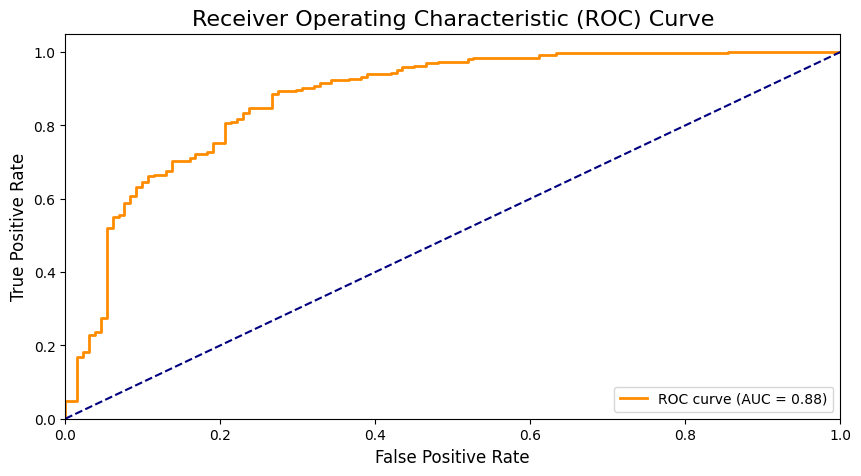

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# ------------------------
# Function to plot ROC curve
# ------------------------
def plot_roc(X_test_rf, y_test_rf, estimator, lns=100):
    # Predict probabilities
    y_pred_prob = estimator.predict_proba(X_test_rf)[:, 1]

    # Compute ROC curve and area under the curve
    fpr, tpr, _ = roc_curve(y_test_rf, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()

# ------------------------
# Define the pipeline
# ------------------------
model_rf = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# ------------------------
# Load your dataset (Assume df is your DataFrame)
# ------------------------
# Assuming df is your DataFrame containing 'Sentence' and 'Sentiment' columns
X_rf = df['Sentence'].values
y_rf = df['Sentiment'].values

# Encode labels
label_encoder = LabelEncoder()
y_rf = label_encoder.fit_transform(y_rf)

# ------------------------
# Split the data into train/test sets
# ------------------------
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# ------------------------
# Fit the model
# ------------------------
model_rf.fit(X_train_rf, y_train_rf)

# ------------------------
# Evaluate the model on train/test sets
# ------------------------
y_train_pred_rf = model_rf.predict(X_train_rf)
y_test_pred_rf = model_rf.predict(X_test_rf)

# ------------------------
# Calculate evaluation metrics
# ------------------------
train_accuracy_rf = accuracy_score(y_train_rf, y_train_pred_rf)
train_precision_rf = precision_score(y_train_rf, y_train_pred_rf)
train_recall_rf = recall_score(y_train_rf, y_train_pred_rf)
train_f1_rf = f1_score(y_train_rf, y_train_pred_rf)

test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf)
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf)
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf)

# ------------------------
# Print the metrics
# ------------------------
print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy_rf:.4f}")
print(f"Precision: {train_precision_rf:.4f}")
print(f"Recall: {train_recall_rf:.4f}")
print(f"F1 Score: {train_f1_rf:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"F1 Score: {test_f1_rf:.4f}")

# ------------------------
# Plot the ROC curve
# ------------------------
plot_roc(X_test_rf, y_test_rf, estimator=model_rf)

# final comparison

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ------------------------
# 1. Random Forest Model Evaluation
# ------------------------

# Predictions for Random Forest
y_train_pred_rf = model_rf.predict(X_train_rf)
y_test_pred_rf = model_rf.predict(X_test_rf)

# Calculate evaluation metrics for Random Forest
train_accuracy_rf = accuracy_score(y_train_rf, y_train_pred_rf)
train_precision_rf = precision_score(y_train_rf, y_train_pred_rf)
train_recall_rf = recall_score(y_train_rf, y_train_pred_rf)
train_f1_rf = f1_score(y_train_rf, y_train_pred_rf)

test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf)
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf)
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf)

# Print metrics for Random Forest
print("\nRandom Forest - Training Metrics:")
print(f"Accuracy: {train_accuracy_rf:.4f}, Precision: {train_precision_rf:.4f}, Recall: {train_recall_rf:.4f}, F1 Score: {train_f1_rf:.4f}")
print("\nRandom Forest - Test Metrics:")
print(f"Accuracy: {test_accuracy_rf:.4f}, Precision: {test_precision_rf:.4f}, Recall: {test_recall_rf:.4f}, F1 Score: {test_f1_rf:.4f}")

# ------------------------
# 2. XGBoost Model Evaluation
# ------------------------

# Predictions for XGBoost
train_results_xgb = xgb_model.predict(X_train_xgb)
test_results_xgb = xgb_model.predict(X_test_xgb)

# Convert predictions to binary
y_train_pred_xgb = (train_results_xgb > 0.5).astype(int)
y_test_pred_xgb = (test_results_xgb > 0.5).astype(int)

# Calculate evaluation metrics for XGBoost
train_accuracy_xgb = accuracy_score(y_train_xgb, y_train_pred_xgb)
train_precision_xgb = precision_score(y_train_xgb, y_train_pred_xgb)
train_recall_xgb = recall_score(y_train_xgb, y_train_pred_xgb)
train_f1_xgb = f1_score(y_train_xgb, y_train_pred_xgb)
train_auc_xgb = roc_auc_score(y_train_xgb, train_results_xgb)

test_accuracy_xgb = accuracy_score(y_test_xgb, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test_xgb, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test_xgb, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test_xgb, y_test_pred_xgb)
test_auc_xgb = roc_auc_score(y_test_xgb, test_results_xgb)

# Print metrics for XGBoost
print("\nXGBoost - Training Metrics:")
print(f"Accuracy: {train_accuracy_xgb:.4f}, Precision: {train_precision_xgb:.4f}, Recall: {train_recall_xgb:.4f}, F1 Score: {train_f1_xgb:.4f}, AUC: {train_auc_xgb:.4f}")
print("\nXGBoost - Test Metrics:")
print(f"Accuracy: {test_accuracy_xgb:.4f}, Precision: {test_precision_xgb:.4f}, Recall: {test_recall_xgb:.4f}, F1 Score: {test_f1_xgb:.4f}, AUC: {test_auc_xgb:.4f}")

# ------------------------
# 3. CNN Model Evaluation
# ------------------------

# Evaluate CNN model on train/test data
train_results_cnn = best_model.evaluate(X_train, y_train, verbose=1)
test_results_cnn = best_model.evaluate(X_test, y_test, verbose=1)

# Convert predictions to binary
y_train_pred_cnn = (best_model.predict(X_train) > 0.5).astype(int)
y_test_pred_cnn = (best_model.predict(X_test) > 0.5).astype(int)

# Calculate evaluation metrics for CNN
train_precision_cnn = precision_score(y_train, y_train_pred_cnn)
train_recall_cnn = recall_score(y_train, y_train_pred_cnn)
train_f1_cnn = f1_score(y_train, y_train_pred_cnn)
train_auc_cnn = roc_auc_score(y_train, best_model.predict(X_train))

test_precision_cnn = precision_score(y_test, y_test_pred_cnn)
test_recall_cnn = recall_score(y_test, y_test_pred_cnn)
test_f1_cnn = f1_score(y_test, y_test_pred_cnn)
test_auc_cnn = roc_auc_score(y_test, best_model.predict(X_test))

# Print metrics for CNN
print("\nCNN - Training Metrics:")
print(f"Loss: {train_results_cnn[0]:.4f}, Accuracy: {train_results_cnn[1] * 100:.2f}%")
print(f"Precision: {train_precision_cnn:.4f}, Recall: {train_recall_cnn:.4f}, F1 Score: {train_f1_cnn:.4f}, AUC: {train_auc_cnn:.4f}")

print("\nCNN - Test Metrics:")
print(f"Loss: {test_results_cnn[0]:.4f}, Accuracy: {test_results_cnn[1] * 100:.2f}%")
print(f"Precision: {test_precision_cnn:.4f}, Recall: {test_recall_cnn:.4f}, F1 Score: {test_f1_cnn:.4f}, AUC: {test_auc_cnn:.4f}")

# ------------------------
# Summary Comparison Table
# ------------------------
models = ["Random Forest", "XGBoost", "CNN"]
train_accuracies = [train_accuracy_rf, train_accuracy_xgb, train_results_cnn[1]]
test_accuracies = [test_accuracy_rf, test_accuracy_xgb, test_results_cnn[1]]

summary_df = pd.DataFrame({
    "Model": models,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies
})

print("\nSummary Comparison Table:")
print(summary_df)


Random Forest - Training Metrics:
Accuracy: 0.7209, Precision: 0.7147, Recall: 1.0000, F1 Score: 0.8336

Random Forest - Test Metrics:
Accuracy: 0.6726, Precision: 0.6709, Recall: 1.0000, F1 Score: 0.8031

XGBoost - Training Metrics:
Accuracy: 0.9870, Precision: 0.9838, Recall: 0.9975, F1 Score: 0.9906, AUC: 0.9806

XGBoost - Test Metrics:
Accuracy: 0.8629, Precision: 0.8808, Recall: 0.9366, F1 Score: 0.9078, AUC: 0.8047
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0252
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.4955 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

CNN - Training Metrics:
Loss: 0.0479, Accuracy: 98.70%
Precision: 0.9871, Recall: 0.9943, F1 Score: 0.9907, AUC: 0.9985

CNN - Test Metrics:
Loss: 0.4333, Accuracy: 84.77%
Precision: 0.8333, Recall: 0.9615, F1 Score: 0.8929, AUC: 0.9210

Summary Comparison Table:
          


Random Forest - Training Metrics:
Accuracy:  0.7209
Precision: 0.7147, Recall: 1.0000, F1: 0.8336

Random Forest - Test Metrics:
Accuracy:  0.6726
Precision: 0.6709, Recall: 1.0000, F1: 0.8031

XGBoost - Training Metrics:
Accuracy:  0.9870
Precision: 0.9838, Recall: 0.9975, F1: 0.9906, AUC: 0.9806

XGBoost - Test Metrics:
Accuracy:  0.8629
Precision: 0.8808, Recall: 0.9366, F1: 0.9078, AUC: 0.8047
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0252
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.4955 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

CNN - Training Metrics:
Loss: 0.0479, Accuracy: 98.70%
Precision: 0.9871, Recall: 0.9943, F1: 0.9907, AUC: 0.9985

CNN - Test Metrics:
Loss: 0.4333, Accuracy: 84.77%
Precision: 0.8333, Recall: 0.9615, F1: 0.8929, AUC: 0.9210

Summary Comparison Table:
           Model  Train Accuracy  Test Accurac

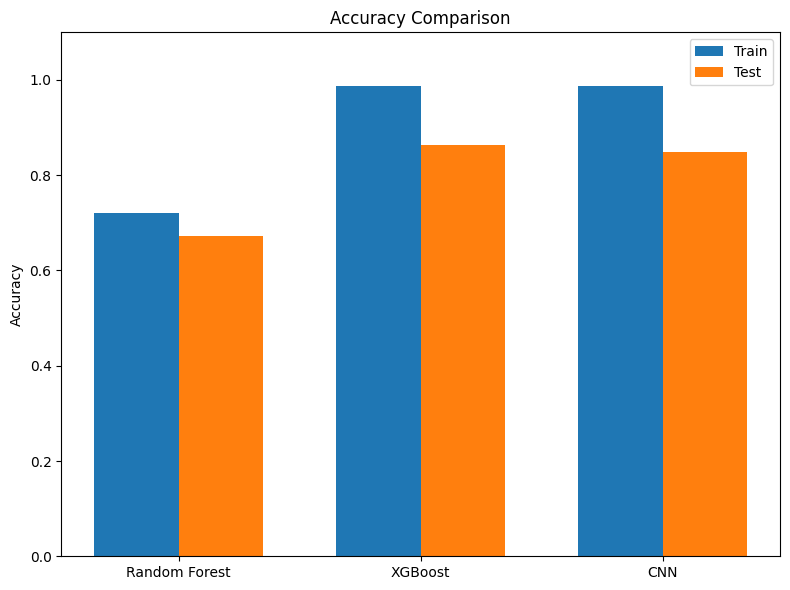

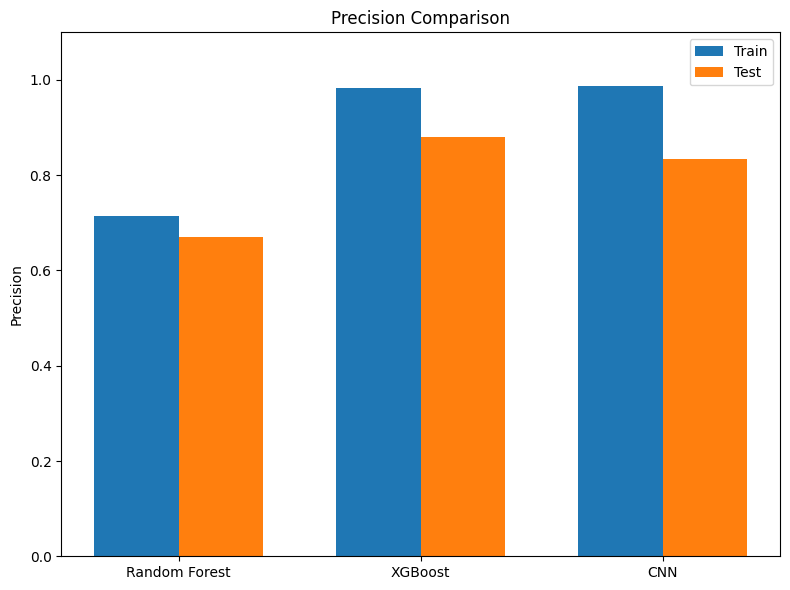

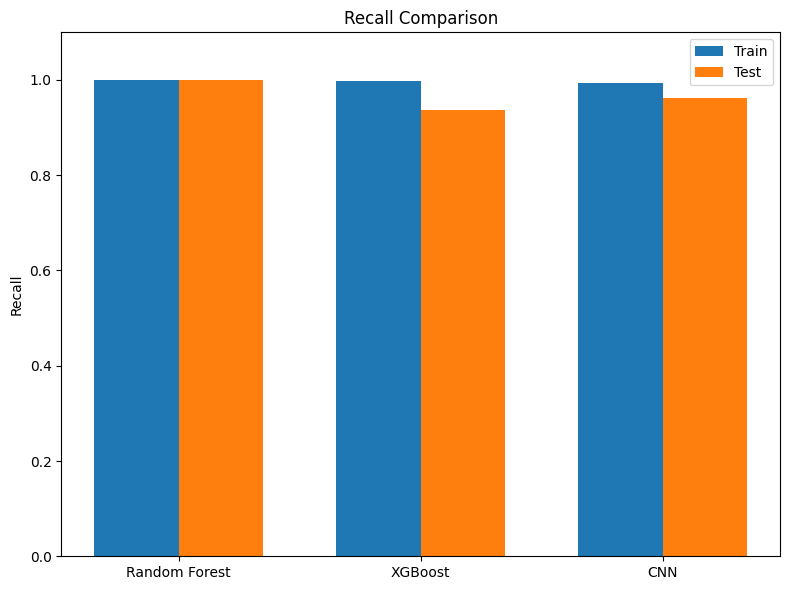

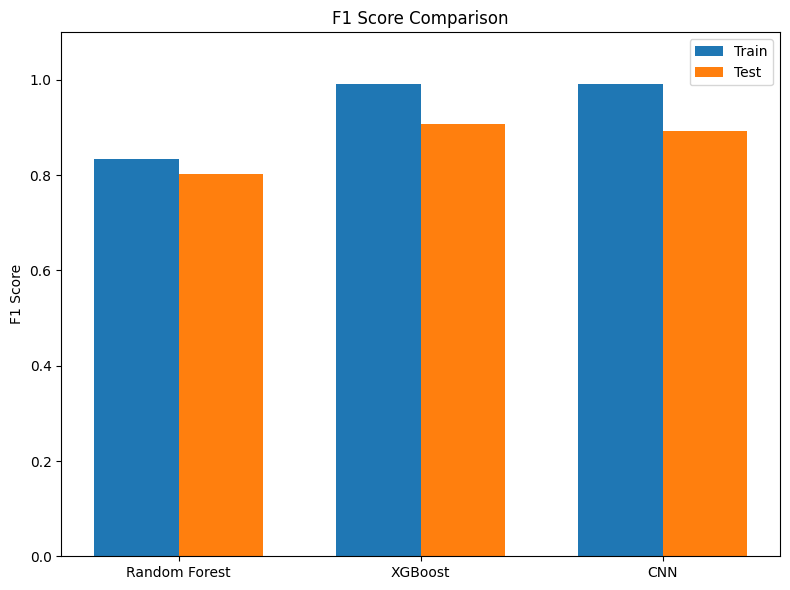

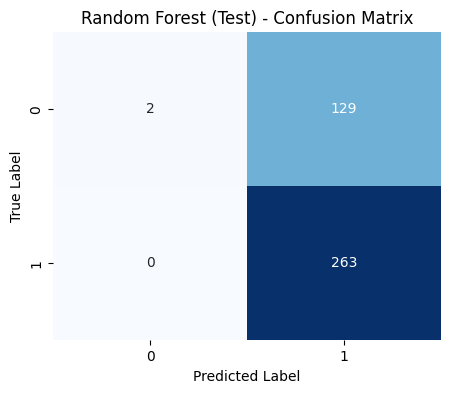

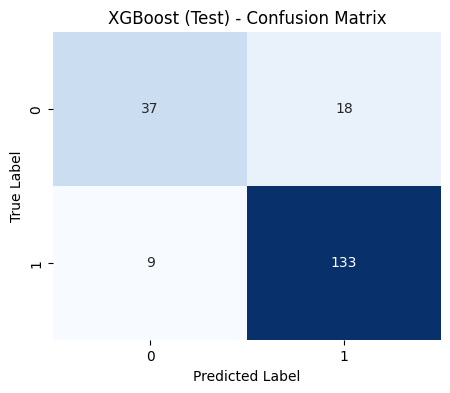

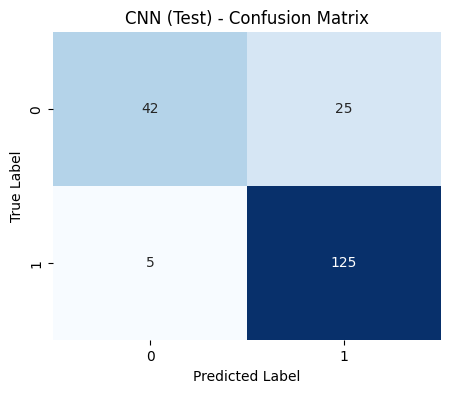

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


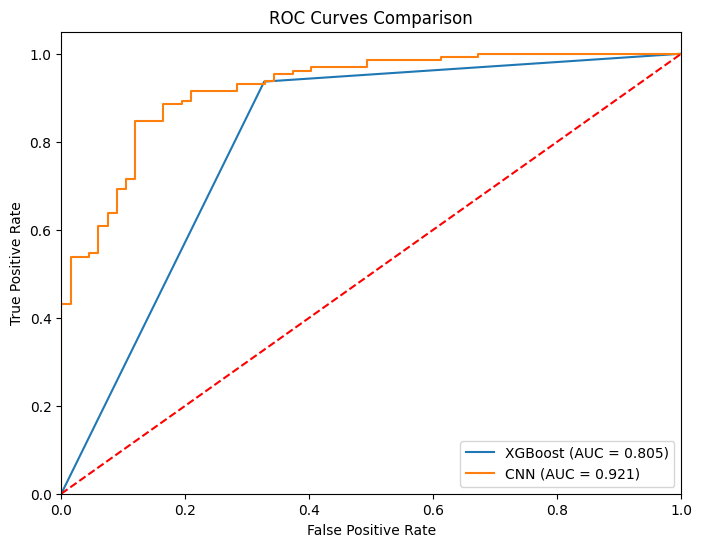

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)

# ------------------------
# 1. Random Forest Model Evaluation
# ------------------------

# Predictions for Random Forest
y_train_pred_rf = model_rf.predict(X_train_rf)
y_test_pred_rf = model_rf.predict(X_test_rf)

# Calculate evaluation metrics for Random Forest (Train)
train_accuracy_rf = accuracy_score(y_train_rf, y_train_pred_rf)
train_precision_rf = precision_score(y_train_rf, y_train_pred_rf)
train_recall_rf = recall_score(y_train_rf, y_train_pred_rf)
train_f1_rf = f1_score(y_train_rf, y_train_pred_rf)
# If you want AUC for RF:
# train_proba_rf = model_rf.predict_proba(X_train_rf)[:, 1]
# train_auc_rf = roc_auc_score(y_train_rf, train_proba_rf)

# Calculate evaluation metrics for Random Forest (Test)
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf)
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf)
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf)
# test_proba_rf = model_rf.predict_proba(X_test_rf)[:, 1]
# test_auc_rf = roc_auc_score(y_test_rf, test_proba_rf)

# Print metrics for Random Forest
print("\nRandom Forest - Training Metrics:")
print(f"Accuracy:  {train_accuracy_rf:.4f}")
print(f"Precision: {train_precision_rf:.4f}, Recall: {train_recall_rf:.4f}, F1: {train_f1_rf:.4f}")
# print(f"AUC:       {train_auc_rf:.4f}")

print("\nRandom Forest - Test Metrics:")
print(f"Accuracy:  {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}, Recall: {test_recall_rf:.4f}, F1: {test_f1_rf:.4f}")
# print(f"AUC:       {test_auc_rf:.4f}")

# ------------------------
# 2. XGBoost Model Evaluation
# ------------------------

# Predictions for XGBoost (probabilities)
train_results_xgb = xgb_model.predict(X_train_xgb)
test_results_xgb = xgb_model.predict(X_test_xgb)

# Convert predictions to binary
y_train_pred_xgb = (train_results_xgb > 0.5).astype(int)
y_test_pred_xgb = (test_results_xgb > 0.5).astype(int)

# Calculate evaluation metrics for XGBoost (Train)
train_accuracy_xgb = accuracy_score(y_train_xgb, y_train_pred_xgb)
train_precision_xgb = precision_score(y_train_xgb, y_train_pred_xgb)
train_recall_xgb = recall_score(y_train_xgb, y_train_pred_xgb)
train_f1_xgb = f1_score(y_train_xgb, y_train_pred_xgb)
train_auc_xgb = roc_auc_score(y_train_xgb, train_results_xgb)

# Calculate evaluation metrics for XGBoost (Test)
test_accuracy_xgb = accuracy_score(y_test_xgb, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test_xgb, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test_xgb, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test_xgb, y_test_pred_xgb)
test_auc_xgb = roc_auc_score(y_test_xgb, test_results_xgb)

# Print metrics for XGBoost
print("\nXGBoost - Training Metrics:")
print(f"Accuracy:  {train_accuracy_xgb:.4f}")
print(f"Precision: {train_precision_xgb:.4f}, Recall: {train_recall_xgb:.4f}, F1: {train_f1_xgb:.4f}, AUC: {train_auc_xgb:.4f}")

print("\nXGBoost - Test Metrics:")
print(f"Accuracy:  {test_accuracy_xgb:.4f}")
print(f"Precision: {test_precision_xgb:.4f}, Recall: {test_recall_xgb:.4f}, F1: {test_f1_xgb:.4f}, AUC: {test_auc_xgb:.4f}")

# ------------------------
# 3. CNN Model Evaluation
# ------------------------

# Evaluate CNN model on train/test data
train_results_cnn = best_model.evaluate(X_train, y_train, verbose=1)
test_results_cnn = best_model.evaluate(X_test, y_test, verbose=1)

# Convert predictions to binary
y_train_pred_cnn = (best_model.predict(X_train) > 0.5).astype(int)
y_test_pred_cnn = (best_model.predict(X_test) > 0.5).astype(int)

# Calculate evaluation metrics for CNN (Train)
train_precision_cnn = precision_score(y_train, y_train_pred_cnn)
train_recall_cnn = recall_score(y_train, y_train_pred_cnn)
train_f1_cnn = f1_score(y_train, y_train_pred_cnn)
train_auc_cnn = roc_auc_score(y_train, best_model.predict(X_train))

# Calculate evaluation metrics for CNN (Test)
test_precision_cnn = precision_score(y_test, y_test_pred_cnn)
test_recall_cnn = recall_score(y_test, y_test_pred_cnn)
test_f1_cnn = f1_score(y_test, y_test_pred_cnn)
test_auc_cnn = roc_auc_score(y_test, best_model.predict(X_test))

# Print metrics for CNN
print("\nCNN - Training Metrics:")
print(f"Loss: {train_results_cnn[0]:.4f}, Accuracy: {train_results_cnn[1]*100:.2f}%")
print(f"Precision: {train_precision_cnn:.4f}, Recall: {train_recall_cnn:.4f}, F1: {train_f1_cnn:.4f}, AUC: {train_auc_cnn:.4f}")

print("\nCNN - Test Metrics:")
print(f"Loss: {test_results_cnn[0]:.4f}, Accuracy: {test_results_cnn[1]*100:.2f}%")
print(f"Precision: {test_precision_cnn:.4f}, Recall: {test_recall_cnn:.4f}, F1: {test_f1_cnn:.4f}, AUC: {test_auc_cnn:.4f}")

# ------------------------
# 4. Summary Comparison Table
# ------------------------
models = ["Random Forest", "XGBoost", "CNN"]
train_accuracies = [train_accuracy_rf, train_accuracy_xgb, train_results_cnn[1]]
test_accuracies = [test_accuracy_rf, test_accuracy_xgb, test_results_cnn[1]]

summary_df = pd.DataFrame({
    "Model": models,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies
})

print("\nSummary Comparison Table:")
print(summary_df)

##############################################################################
# OPTIONAL: Visual Comparison (Grouped Bar Charts, Confusion Matrices, ROC)
##############################################################################

# ---------- 4.1 Grouped Bar Charts for Metrics (Train vs Test)  ----------
def plot_comparison_bar(models, train_scores, test_scores, metric_name):
    """
    Creates a side-by-side bar chart comparing training and test scores for different models.
    """
    x = np.arange(len(models))
    width = 0.35
    
    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, train_scores, width, label='Train', color='#1f77b4')
    plt.bar(x + width/2, test_scores, width, label='Test', color='#ff7f0e')
    
    plt.xticks(x, models)
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot bar charts for Accuracy, Precision, Recall, and F1 (AUC only if all models have it)
plot_comparison_bar(models,
                    [train_accuracy_rf, train_accuracy_xgb, train_results_cnn[1]],
                    [test_accuracy_rf, test_accuracy_xgb, test_results_cnn[1]],
                    "Accuracy")

plot_comparison_bar(models,
                    [train_precision_rf, train_precision_xgb, train_precision_cnn],
                    [test_precision_rf, test_precision_xgb, test_precision_cnn],
                    "Precision")

plot_comparison_bar(models,
                    [train_recall_rf, train_recall_xgb, train_recall_cnn],
                    [test_recall_rf, test_recall_xgb, test_recall_cnn],
                    "Recall")

plot_comparison_bar(models,
                    [train_f1_rf, train_f1_xgb, train_f1_cnn],
                    [test_f1_rf, test_f1_xgb, test_f1_cnn],
                    "F1 Score")

# Uncomment below if you have RF AUC values as well
# train_auc_rf = ...
# test_auc_rf = ...
# plot_comparison_bar(models,
#                     [train_auc_rf, train_auc_xgb, train_auc_cnn],
#                     [test_auc_rf, test_auc_xgb, test_auc_cnn],
#                     "AUC")


# ---------- 4.2 Confusion Matrices ----------
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix using Seaborn's heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage for test sets:
plot_confusion_matrix(y_test_rf, y_test_pred_rf, "Random Forest (Test)")
plot_confusion_matrix(y_test_xgb, y_test_pred_xgb, "XGBoost (Test)")
plot_confusion_matrix(y_test, y_test_pred_cnn, "CNN (Test)")


# ---------- 4.3 ROC Curves ----------
def plot_roc_curve(y_true, y_proba, label):
    """
    Plots the ROC curve for a single model.
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.3f})')

plt.figure(figsize=(8, 6))

# Random Forest (if you have probabilities)
# plot_roc_curve(y_test_rf, test_proba_rf, 'Random Forest')

# XGBoost
plot_roc_curve(y_test_xgb, test_results_xgb, 'XGBoost')

# CNN
cnn_proba = best_model.predict(X_test).ravel()
plot_roc_curve(y_test, cnn_proba, 'CNN')

# Plot a diagonal line for reference
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()